<a href="https://colab.research.google.com/github/harmith-singh/IHS-Feature-Selection/blob/main/Linear_Feature_Selection_Algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyforest
!pip install fuzzywuzzy
!pip install treelib
%pip install mlxtend --upgrade

import pyforest
import os
import datetime
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore')
from google.colab import files

from fuzzywuzzy import fuzz
from treelib import Node, Tree
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_SFS
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

def dump(df, output='dump_output.xlsx'):
  df.reset_index(inplace= True, drop= True)
  df.to_excel(output, index= False, header= True)
  files.download('dump_output.xlsx')

from google.colab import drive
drive.mount('/content/drive')

  Created wheel for pyforest: filename=pyforest-1.1.0-py2.py3-none-any.whl size=14607 sha256=1efe31feabde1f1a7a28d77717e3925280b975216c1afe1492c62ee90777cfdc
  Stored in directory: /root/.cache/pip/wheels/61/1c/da/48e6c884142d485475d852d69d20a096aba5beceb338822893
Successfully built pyforest
  Created wheel for treelib: filename=treelib-1.6.1-py3-none-any.whl size=18385 sha256=dbf59d92b0eefddbcdf7176b43b380a07166a483633e5e68c1a88c695b5cecd5
  Stored in directory: /root/.cache/pip/wheels/89/be/94/2c6d949ce599d1443426d83ba4dc93cd35c0f4638260930a53
Successfully built treelib
     |████████████████████████████████| 1.3 MB 5.4 MB/s 
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0
Mounted at /content/drive


Fact.Sales_2018_2.csv
Fact.Sales_2018_1.csv
Fact.Sales_2020_1.csv
Fact.Sales_2019_2.csv
Fact.Sales_2020_2.csv
Fact.Sales_2019_1.csv
MEX-H1_2021.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/content/drive/MyDrive/Antonio's Data/Mexico Sales Data/Fact.Sales_2018_2.csv (645491, 6)


<IPython.core.display.Javascript object>

(645491, 6) 



<IPython.core.display.Javascript object>

/content/drive/MyDrive/Antonio's Data/Mexico Sales Data/Fact.Sales_2018_1.csv (623230, 6)


<IPython.core.display.Javascript object>

(1268721, 6) 



<IPython.core.display.Javascript object>

/content/drive/MyDrive/Antonio's Data/Mexico Sales Data/Fact.Sales_2020_1.csv (575732, 6)


<IPython.core.display.Javascript object>

(1844453, 6) 



<IPython.core.display.Javascript object>

/content/drive/MyDrive/Antonio's Data/Mexico Sales Data/Fact.Sales_2019_2.csv (749521, 6)


<IPython.core.display.Javascript object>

(2593974, 6) 



<IPython.core.display.Javascript object>

/content/drive/MyDrive/Antonio's Data/Mexico Sales Data/Fact.Sales_2020_2.csv (742549, 6)


<IPython.core.display.Javascript object>

(3336523, 6) 



<IPython.core.display.Javascript object>

/content/drive/MyDrive/Antonio's Data/Mexico Sales Data/Fact.Sales_2019_1.csv (661124, 6)


<IPython.core.display.Javascript object>

(3997647, 6) 



<IPython.core.display.Javascript object>

/content/drive/MyDrive/Antonio's Data/Mexico Sales Data/MEX-H1_2021.csv (779262, 6)


<IPython.core.display.Javascript object>

(4776909, 6) 



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

        country       date      TPI        DPG  actual_sales
0            MX 2018-01-08  3000003  100015989      451.9008
1            MX 2018-01-08  3000003  100015990      265.8240
2            MX 2018-01-08  3000003  100015994      429.4080
3            MX 2018-01-08  3000003  100017727       14.3136
4            MX 2018-01-08  3000003  100195993       97.1280
...         ...        ...      ...        ...           ...
1746979      MX 2021-06-25  3009397       FP10       12.6096
1746980      MX 2021-06-25  3009397       FP29        2.1300
1746981      MX 2021-06-25  3009397       FP30        7.1568
1746982      MX 2021-06-25  3009397       FX00        9.0312
1746983      MX 2021-06-25  3009397       FX04        0.5964

[1729591 rows x 5 columns]


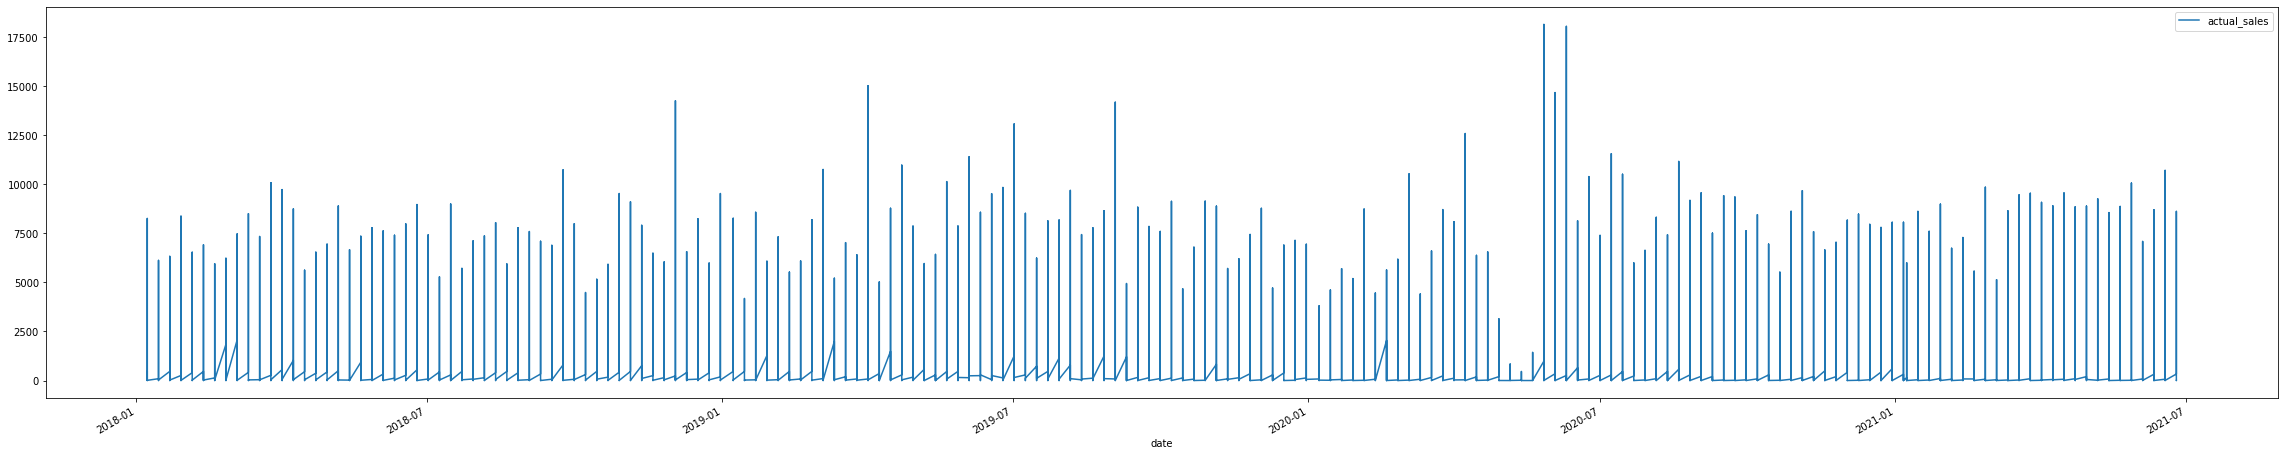

In [ ]:
# Joining MX data from O9
local_download_path = "/content/drive/MyDrive/Antonio's Data/Mexico Sales Data/"

file_list = []

for filename in os.listdir(local_download_path):
    if filename.endswith("csv"): 
        # Your code comes here such as 
        print(filename)
        file_list.append(local_download_path+filename)

#--

#concatinating datasets
df = pd.DataFrame()
print('')
for file in file_list:

  df_ = pd.read_csv(file)
  print(file, df_.shape)
  df = pd.concat([df, df_], ignore_index= True)
  print(df.shape, '\n')

#--

#convert partial-weeks to weeks
df.reset_index(inplace= True, drop=True)
df['date'] = pd.to_datetime(df['Time.[PartialWeek]'])
df['year'] = df['date'].dt.year
df['weeknum'] = df['date'].dt.isocalendar().week

def make_date(year, weeknum):
  return datetime.date(year, 1, 1) + relativedelta(weeks= +weeknum)

df['date_new'] = df.apply(lambda row: make_date(row['year'], row['weeknum']), axis= 1)
df['date_new'] = pd.to_datetime(df['date_new'])

#--

#aggregating, renaming columns
df = df.groupby(['date_new', 'Item.[Transition Planning Item]', 'Sales Domain.[Transition DPG]'])\
       .agg(actual_sales = ('ActualInput Initial', 'sum'))\
       .reset_index()
       ##since we're summing across all intersections, so there is no longer a need to do df.fillna(0)
       
df.insert(0, 'country', 'MX')
df = df.rename(columns= {'date_new': 'date',\
                        'Item.[Transition Planning Item]': 'TPI',\
                        'Sales Domain.[Transition DPG]': 'DPG'})

#--

#imputing negative values with 0 --this step is debatable, but since O9 performs it so kept here
df['actual_sales'] = df['actual_sales'].clip(lower=0)

#--

#manual_inspection --removing some weird things from dataset
'''
do a basic sanity check using:
  1. df.date.unique() --> found some weird dates ['2021-07-02T00:00:00.000000000', '2022-01-07T00:00:00.000000000']
  2. df.TPI.unique()
  3. df.DPG.unique() --> found some weird DPGs ['DEXMOD', '0', 'BX14']
  4. df.plot.line(x= 'date', y= 'actual_sales', figsize= (40,8)) --> a visual inspection of volumes
'''
df = df[(df.DPG != 'DEXMOD') & (df.DPG != '0') & (df.DPG != 'BX14')]
df = df[df.date <= '2021-06-25']

#--

#taking backup, plot of dataset
df_mx = df.copy(deep= True)
print(df)
df.plot.line(x= 'date', y= 'actual_sales', figsize= (40,8));

In [ ]:
# Doing ABCD-WXYZ, Life-cycle segmentation
df['key'] = df['TPI'].astype('str').str.strip() + ':' + df['DPG'].astype('str').str.strip()
print('No. of unique TPI-DPG intersections =', len(df['key'].unique()), '\n')

#--

#calculating avg_sales and then cumulative avg_sales
df_vols = df.groupby(['key'])\
            .agg(avg_sales = ('actual_sales', 'mean'))\
            .sort_values(['avg_sales'], ascending= False)\
            .reset_index()

df_vols['cum_sales'] = df_vols['avg_sales'].cumsum()
df_vols['%cum_sales'] = df_vols['cum_sales']/df_vols['avg_sales'].sum()
print(df_vols)

#--

#binning as per %cum_sales-- last bin is >1 to include keys with %cum_sales==1
df_vols['vol_seg'] = pd.cut(df_vols['%cum_sales'],\
                            bins=[0, .8, .95, .995, 1.01],\
                            labels=['A', 'B', 'C', 'D'],\
                            include_lowest= True)

print('\nVolume Segments and their counts:')
print(df_vols['vol_seg'].value_counts())
print('Total\t', df_vols['vol_seg'].value_counts().sum())

#--

#calculating coefficient-of-variation
df_cov = df.groupby(['key'])\
           .agg(avg_sales = ('actual_sales', 'mean'), sd_sales = ('actual_sales', 'std'))\
           .reset_index()

df_cov['cov'] = df_cov['sd_sales']/df_cov['avg_sales']
print(df_cov)

#--

#binning as per COV value-- last bin is infinity here to grab all remainder values
df_cov['cov_seg'] = pd.cut(df_cov['cov'],\
                           bins=[0, .5, 1, 2, np.inf],\
                           labels= ['W', 'X', 'Y', 'Z'],\
                           include_lowest= True)
##binning NaN COV values as 'Z'
df_cov['cov_seg'] = df_cov['cov_seg'].fillna('Z')

print('\nCOV Segments and their counts:')
print(df_cov['cov_seg'].value_counts())
print('Total\t', df_cov['cov_seg'].value_counts().sum())

#--

#adding vol_seg, cov_seg to main dataset
df = pd.merge(df, df_vols[['key', 'vol_seg']], on= 'key', how= 'left')
df = pd.merge(df, df_cov[['key', 'cov_seg']], on= 'key', how= 'left')

df['sub_seg'] = df['vol_seg'].astype('str') + df['cov_seg'].astype('str')

print('\nFinal Sub-segments and their counts, market share:')
print(df['sub_seg'].value_counts())
print('Total\t', df['sub_seg'].value_counts().sum(), '\n')

#--

#printing sub-segments and their market shares
df_ = df.groupby(['sub_seg'])\
        .agg(actual_sales = ('actual_sales', 'sum'))\
        .reset_index()
df_['%share'] = df_['actual_sales']/df_['actual_sales'].sum()

df_ = df_.sort_values(by= ['%share'], ascending= False)\
         .reset_index(drop=True)
df_['%cumshare']  = df_['%share'].cumsum()
print(df_)

#--

#life-cycle segmentation into Mature, NPI, EOL is skipped for now

#--

#taking backup
df_seg = df.copy(deep= True)
df

No. of unique TPI-DPG intersections = 25556 

                key    avg_sales     cum_sales  %cum_sales
0      3001268:FC00  6888.319884  6.888320e+03    0.005490
1      3008329:FT00  5217.601225  1.210592e+04    0.009649
2      3000022:FK00  4955.338315  1.706126e+04    0.013598
3      3000022:GE06  4172.115889  2.123338e+04    0.016923
4      3001268:FP11  4138.557945  2.537193e+04    0.020222
...             ...          ...           ...         ...
25551  3007531:FY00     0.000000  1.254688e+06    1.000000
25552  3006198:FS00     0.000000  1.254688e+06    1.000000
25553  3001463:FP07     0.000000  1.254688e+06    1.000000
25554  3001507:FE17     0.000000  1.254688e+06    1.000000
25555  3000191:FB04     0.000000  1.254688e+06    1.000000

[25556 rows x 4 columns]


<IPython.core.display.Javascript object>


Volume Segments and their counts:
D    9656
C    8861
B    4605
A    2434
Name: vol_seg, dtype: int64
Total	 25556
                     key   avg_sales    sd_sales       cov
0      3000003:100015989  302.211397  246.262910  0.814870
1      3000003:100015990  203.585411  201.059690  0.987594
2      3000003:100015992   46.568671   36.786362  0.789938
3      3000003:100015994  589.136100  426.609552  0.724127
4      3000003:100016000  148.346948  102.787007  0.692883
...                  ...         ...         ...       ...
25551       3009397:FP10   14.285200   12.989112  0.909271
25552       3009397:FP29    3.195000    1.506137  0.471405
25553       3009397:FP30    7.156800         NaN       NaN
25554       3009397:FX00    9.031200         NaN       NaN
25555       3009397:FX04    3.195000    3.674975  1.150227

[25556 rows x 4 columns]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


COV Segments and their counts:
X    13899
Y     6585
W     3065
Z     2007
Name: cov_seg, dtype: int64
Total	 25556


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Final Sub-segments and their counts, market share:
CX    391555
BX    256632
DX    206990
AX    189811
CY    168610
DY    133869
AW    106082
BW     66499
BY     64844
CW     47363
CZ     33733
BZ     23682
AY     16998
DZ     10612
DW      8080
AZ      4231
Name: sub_seg, dtype: int64
Total	 1729591 

   sub_seg  actual_sales    %share  %cumshare
0       AX  7.956648e+07  0.460384   0.460384
1       AW  6.630799e+07  0.383668   0.844052
2       BX  1.091040e+07  0.063129   0.907182
3       AY  4.212857e+06  0.024376   0.931558
4       BW  2.956512e+06  0.017107   0.948665
5       BY  2.664483e+06  0.015417   0.964082
6       CX  2.622623e+06  0.015175   0.979257
7       CY  1.007679e+06  0.005831   0.985087
8       BZ  9.786375e+05  0.005663   0.990750
9       AZ  6.818907e+05  0.003946   0.994696
10      CW  3.953655e+05  0.002288   0.996983
11      CZ  2.319832e+05  0.001342   0.998325
12      DX  1.633483e+05  0.000945   0.999271
13      DY  1.105710e+05  0.000640   0.999910
14   

,country,date,TPI,DPG,actual_sales,key,vol_seg,cov_seg,sub_seg
0,MX,2018-01-08,3000003,100015989,451.9008,3000003:100015989,A,X,AX
1,MX,2018-01-08,3000003,100015990,265.8240,3000003:100015990,A,X,AX
2,MX,2018-01-08,3000003,100015994,429.4080,3000003:100015994,A,X,AX
3,MX,2018-01-08,3000003,100017727,14.3136,3000003:100017727,B,Y,BY
4,MX,2018-01-08,3000003,100195993,97.1280,3000003:100195993,B,X,BX
...,...,...,...,...,...,...,...,...,...
1729586,MX,2021-06-25,3009397,FP10,12.6096,3009397:FP10,C,X,CX
1729587,MX,2021-06-25,3009397,FP29,2.1300,3009397:FP29,C,W,CW
1729588,MX,2021-06-25,3009397,FP30,7.1568,3009397:FP30,C,Z,CZ
1729589,MX,2021-06-25,3009397,FX00,9.0312,3009397:FX00,C,Z,CZ


In [ ]:
# Creating features dataset
filepath = '/content/drive/MyDrive/IHS_Mexico_2022-01-17_1.csv'
feat_df = pd.read_csv(filepath)
'''
Here we'll first undergo a variety of Dimensionality-reduction techniques to pass on only limited IHS features for feature-selection:
  1. Removing "_annual" features
  2. High Covariance Filter on "_month" features
  3. High Covariance Filter on "_quarter" features
  4. Similar looking "_month" and "_quarter" features--> dropped "_quarter" ones since "_month" ones are more granular
  5. Similar looking "_month" features
  6. Similar looking "_quarter" features
  7. Low variance filter on "_month" and "_quarter" features

Ordering in which these steps are applied, matters a lot!
'''

#--

#adding date column, dropping unnecessary ones
feat_df['date_month'] = pd.to_datetime(feat_df['Period'])
feat_df = feat_df.drop(['Geography', 'Period'], axis= 1)
print('Original features dataset shape:', feat_df.shape)

#--

#dropping all "_annual" features-- none of annual features will be of use as at max we'd have 5 unique values from 2018-2022
drop_list = []
for col in feat_df.columns:
  if '_annual' in col.lower(): drop_list.append(col)

feat_df = feat_df.drop(drop_list, axis= 1)
print('Dropped {} "_annual" features from the dataset. Now {} features remain\n'.format(len(drop_list), len(feat_df.columns)))

#--

#dropping self-correlated monthly features-- removing monthly features which have a high correlation amongst them
correlation_factor = 0.9
month_feat = []
for col in feat_df.columns:
  if '_month' in col.lower(): month_feat.append(col)
print('Evaluating {} "_month" features for correlation'.format(len(month_feat)))

df_ = feat_df[month_feat]
##plotting the correlation matrix
corr_matrix = df_.corr().abs()
##focussing only on the upper triangular matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
##plot the upper-triangular/correlation matrix using below code
##plt.figure(figsize= (10,8))
##sns.heatmap(upper, xticklabels= False)
##plt.show()
drop_list = [column for column in upper.columns if any(upper[column] > correlation_factor)]

feat_df = feat_df.drop(drop_list, axis= 1)
print('Dropped {} "_month" features from the dataset. Now {} features remain\n'.format(len(drop_list), len(feat_df.columns)))

#--

#dropping self-correlated quarterly features-- removing quarterly features which have a high correlation amongst them
correlation_factor = 0.9
quarter_feat = []
for col in feat_df.columns:
  if '_quarter' in col.lower(): quarter_feat.append(col)
print('Evaluating {} "_quarter" features for correlation'.format(len(quarter_feat)))

df_ = feat_df[quarter_feat]
corr_matrix = df_.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
drop_list = [column for column in upper.columns if any(upper[column] > correlation_factor)]

feat_df = feat_df.drop(drop_list, axis= 1)
print('Dropped {} "_quarter" features from the dataset. Now {} features remain\n'.format(len(drop_list), len(feat_df.columns)))

#--

#dropping those quarterly features which have similar looking monthly features available
month_feat, quarter_feat = [], []
for col in feat_df.columns:
  if '_month' in col.lower(): month_feat.append(col)
  elif '_quarter' in col.lower(): quarter_feat.append(col)

  ##writing a function to drop similar looking features at multiple levels
def drop_similar_features(df, level1, level2, grade= 70, show_tree= True):
  sim_dict = {}
  for i in level1:
    ###say if month features are compared against quarter features for similarity
    if level1 != level2:
      for j in level2:
        if fuzz.ratio(i, j) > grade: sim_dict[i] = sim_dict.get(i, []) + [j]

    ###say if month features are compared against month features for similarity
    elif level1 == level2:
      for j in level1[level1.index(i)+1:]:
        if fuzz.ratio(i, j) > grade: sim_dict[i] = sim_dict.get(i, []) + [j]

  ##visualizing results via similarity tree-- totally independent component
  tree = Tree()
  tree.create_node('SIMILARITY TREE', 'root')
  for key in sim_dict.keys():
    tree.create_node(key, key.upper(), parent= 'root')

  start = 0
  for item in sim_dict.items():
    for val in item[1]:
      tree.create_node(val, val.upper()+'_'+str(start), parent = item[0].upper())
    start+= 1
  if show_tree:
    tree.show()

  drop_list = []
  for val in sim_dict.values():
    drop_list += val
    ##the dropping procedure has to be made immune incase the column does not exist in the dataset
  drop_list = list(set(drop_list))
  for col in drop_list:
    if col in df.columns: df = df.drop(col, axis= 1)
  print('Dropped {} similar looking features from the dataset. Now {} features remain\n'.format(len(drop_list), len(df.columns)))
  return df

print('Evaluating {} "_month" and {} "_quarter" features for similarity'.format(len(month_feat), len(quarter_feat)))
feat_df = drop_similar_features(feat_df, month_feat, quarter_feat, grade= 70, show_tree= True)

#--

#dropping those monthly, quarterly features which have self-similar looking features available
month_feat, quarter_feat = [], []
for col in feat_df.columns:
  if '_month' in col.lower(): month_feat.append(col)
  elif '_quarter' in col.lower(): quarter_feat.append(col)

print('Evaluating {} "_month" features for self-similarity'.format(len(month_feat)))
feat_df = drop_similar_features(feat_df, month_feat, month_feat, grade= 70, show_tree= True)

print('Evaluating {} "_quarter" features for self-similarity'.format(len(quarter_feat)))
feat_df = drop_similar_features(feat_df, quarter_feat, quarter_feat, grade= 70, show_tree= True)

#--

#applying Low Variance Filter on remaining features-- removes features whose value does change/stays constant over time
minimum_variance_filter = 0.1
variance_dict = {}
for col in [x for x in feat_df if x not in ['date_month']]:
  variance_dict[col] = variance_dict.get(col, feat_df[col].var())

print('Evaluating {} features for low variance'.format(len(feat_df.columns)))
drop_list = []
for item in variance_dict.items():
  if item[1] <= minimum_variance_filter: drop_list.append(item[0])

feat_df = feat_df.drop(drop_list, axis= 1)
print('Dropped {} features from the dataset. Now {} features remain\n'.format(len(drop_list), len(feat_df.columns)))

#--

#joining the features dataset with the volumes dataset
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['day'] = 1
  ##we need to create a date_month column in df to be able to join, because feat_df is at a monthly level
df['date_month'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.drop(['year', 'month', 'day'], axis= 1)

print('Merging features into main dataset')
df = pd.merge(df, feat_df, how= 'inner', on= 'date_month')
  ##droping date_month column, as it is no longer needed. Now the length of feat_df.columns will reduce by 1
df = df.drop('date_month', axis= 1)

#--

#taking backup
df_main = df.copy(deep= True)
df

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Original features dataset shape: (109, 978)
Dropped 656 "_annual" features from the dataset. Now 322 features remain

Evaluating 37 "_month" features for correlation


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Dropped 21 "_month" features from the dataset. Now 301 features remain

Evaluating 285 "_quarter" features for correlation


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Dropped 220 "_quarter" features from the dataset. Now 81 features remain

Evaluating 16 "_month" and 65 "_quarter" features for similarity
SIMILARITY TREE
├── Consumer Price Index_ Dollar Basis_ Year-on-Year Percent Change_Monthly
│   ├── Consumer Price Index_ Dollar Basis_ Quarter-on-Quarter_ SAAR_ Percent Change_Quarterly
│   ├── Consumer Price Index_ Dollar Basis_ Year-on-Year Percent Change_Quarterly
│   ├── Consumer Price Index_ Dollar Basis_Quarterly
│   ├── Consumer Price Index_ Quarter-on-Quarter_ SAAR_ Percent Change_Quarterly
│   ├── Consumer Price Index_ Year-on-Year Percent Change_Quarterly
│   └── Wholesale-Producer Price Index_ Year-on-Year Percent Change_Quarterly
├── Consumer Price Index_ Dollar Basis_Monthly
│   ├── Consumer Price Index_ Dollar Basis_ Year-on-Year Percent Change_Quarterly
│   └── Consumer Price Index_ Dollar Basis_Quarterly
├── Consumer Price Index_ Year-on-Year Percent Change_Monthly
│   ├── Consumer Price Index_ Dollar Basis_ Year-on-Year Percent Cha

<IPython.core.display.Javascript object>

Merging features into main dataset


<IPython.core.display.Javascript object>

,country,date,TPI,DPG,actual_sales,key,vol_seg,cov_seg,sub_seg,Consumer Price Index_Monthly,...,Growth Rate: International Reserves Excluding Gold_ US$_ Quarter-on-Quarter SAAR Percent Change_Quarterly,Growth Rate_ Broad Money Supply_ Period End_ Quarter-on-Quarter_ SAAR_ Percent Change_ US$_Quarterly,Interest Rate: Money Market_Quarterly,International Reserves Excluding Gold_ US$_Quarterly,M1 as Percent of GDP_Quarterly,NIA Imports of Goods & Non-Factor Service Deflator_ U.S. Dollar Basis_ Quarter-on-Quarter Percent Change_ SAAR_Quarterly,NIA Net Exports of Goods & Non-Factor Services_ Year -on- Year_Quarterly,Nominal Fixed Investment_ US$_Quarterly,Nominal NIA Net Exports_ US$_Quarterly,Unemployment Rate_Quarterly
0,MX,2018-01-08,3000003,100015989,451.9008,3000003:100015989,A,X,AX,112.062265,...,4.719787,36.824038,7.750000,172.435033,17.903944,3.732021,1.661261,270.140997,-15.597644,3.323935
1,MX,2018-01-08,3000003,100015990,265.8240,3000003:100015990,A,X,AX,112.062265,...,4.719787,36.824038,7.750000,172.435033,17.903944,3.732021,1.661261,270.140997,-15.597644,3.323935
2,MX,2018-01-08,3000003,100015994,429.4080,3000003:100015994,A,X,AX,112.062265,...,4.719787,36.824038,7.750000,172.435033,17.903944,3.732021,1.661261,270.140997,-15.597644,3.323935
3,MX,2018-01-08,3000003,100017727,14.3136,3000003:100017727,B,Y,BY,112.062265,...,4.719787,36.824038,7.750000,172.435033,17.903944,3.732021,1.661261,270.140997,-15.597644,3.323935
4,MX,2018-01-08,3000003,100195993,97.1280,3000003:100195993,B,X,BX,112.062265,...,4.719787,36.824038,7.750000,172.435033,17.903944,3.732021,1.661261,270.140997,-15.597644,3.323935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1729586,MX,2021-06-25,3009397,FP10,12.6096,3009397:FP10,C,X,CX,129.566002,...,-0.019143,19.916581,4.296667,192.774921,22.061034,20.343498,-11.948057,246.395835,-4.692918,4.198290
1729587,MX,2021-06-25,3009397,FP29,2.1300,3009397:FP29,C,W,CW,129.566002,...,-0.019143,19.916581,4.296667,192.774921,22.061034,20.343498,-11.948057,246.395835,-4.692918,4.198290
1729588,MX,2021-06-25,3009397,FP30,7.1568,3009397:FP30,C,Z,CZ,129.566002,...,-0.019143,19.916581,4.296667,192.774921,22.061034,20.343498,-11.948057,246.395835,-4.692918,4.198290
1729589,MX,2021-06-25,3009397,FX00,9.0312,3009397:FX00,C,Z,CZ,129.566002,...,-0.019143,19.916581,4.296667,192.774921,22.061034,20.343498,-11.948057,246.395835,-4.692918,4.198290


In [ ]:
'''
No longer running PCA or any other dimensionality-reduction algorithm
'''
# #from sklearn.decomposition import PCA
# # Principal component analysis (PCA)-- indexes calculated will be added as features in main dataset
# features_list = [i for i in feat_df.columns if i not in ['date_month']]
# '''
# Here we'll aggregate features at sub-segment level for PCA
# However, forecasting will still happen at TPI X DPG intersection only
# So the newly created PCA indices will be added back as feature columns into the main dataset
# '''
# pca_df = df[['date', 'sub_seg']+features_list].groupby(['date', 'sub_seg'])\
#                                               .mean()\
#                                               .reset_index()

# pca_indices = 5
# pca_results = pd.DataFrame()

# #--

# #looping the PCA run over all sub-segments
# #-------------------------------------loopfor other segments as well
# sub_seg = 'BX'
#   ##selecting only the feature columns to go into PCA algorithm
# df_ = pca_df[pca_df['sub_seg']== sub_seg]\
#             [[col for col in pca_df.columns if col not in ['date', 'sub_seg']]]\
#             .reset_index(drop= True)

#   ##fitting the PCA algorithm
# print('Running PCA algorithm for "{}" sub-segment. Output will have {} indices'.format(sub_seg, pca_indices))
# pca = PCA(n_components= pca_indices)\
#       .fit(df_)

#   ##plotting the results-- how explained-variance-ratio progresses over indices
# print(pca.explained_variance_ratio_, '\n')
# plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.xlabel('number of indices')
# plt.ylabel('cumulative explained variance')
# plt.show();

#   ##saving the results
# results = pca.transform(df_)
# col_headers = ['pca_index_'+str(i) for i in range(1, pca_indices+1)]
# date_ = pca_df[pca_df['sub_seg']== sub_seg]['date']

# results = pd.DataFrame(results, columns= col_headers, index= date_)
# results.insert(0, 'sub_seg', sub_seg)

# results

In [ ]:
# Performing Feature Selection via Backward-feature-elimination, Forward-feature-selection, and its variants
features_list = [i for i in feat_df.columns if i not in ['date_month']]
'''
Since feature selection will be perfomed at sub-segment level, we aggregate features,actual_sales to that level
However, forecasting will still happen at (TPI X DPG) intersection only
The selected features for each sub-segment will be called in at the time of forecasting
'''
df_X = df.groupby(['date', 'sub_seg'])[features_list]\
         .agg('mean')\
         .reset_index()

df_y = df.groupby(['date', 'sub_seg'])['actual_sales']\
         .agg('sum')\
         .reset_index()

fs_results = pd.DataFrame()

#--

#main loop for all sub_segments
#for sub_seg in df_X['sub_seg'].unique():
for sub_seg in ['AW', 'CY']:

  print('\nPerforming Feature Selection for "{}" sub_segment\n'.format(sub_seg))
  results = pd.DataFrame()
  sub_seg = sub_seg
  n_features = 10
  verbosity = 0
  k_fold_cv = 4

  train_X = df_X[df_X['sub_seg']== sub_seg][features_list].reset_index(drop= True)
  train_y = df_y[df_y['sub_seg']== sub_seg]['actual_sales'].reset_index(drop= True)

  ##defining all models at once:
  modelLR_f = SFS(LinearRegression(), k_features= n_features, forward= True, floating= False, verbose= verbosity, scoring= 'neg_mean_squared_error', cv= k_fold_cv)
  modelLR_b = SFS(LinearRegression(), k_features= n_features, forward= False, floating= False, verbose= verbosity, scoring= 'neg_mean_squared_error', cv= k_fold_cv)
  modelLR_ff = SFS(LinearRegression(), k_features= n_features, forward= True, floating= True, verbose= verbosity, scoring= 'neg_mean_squared_error', cv= k_fold_cv)
  modelLR_bf = SFS(LinearRegression(), k_features= n_features, forward= False, floating= True, verbose= verbosity, scoring= 'neg_mean_squared_error', cv= k_fold_cv)

  modelRF_f = SFS(RandomForestRegressor(), k_features= n_features, forward= True, floating= False, verbose= verbosity, scoring= 'neg_mean_squared_error', cv= k_fold_cv)
  modelRF_b = SFS(RandomForestRegressor(), k_features= n_features, forward= False, floating= False, verbose= verbosity, scoring= 'neg_mean_squared_error', cv= k_fold_cv)
  modelRF_ff = SFS(RandomForestRegressor(), k_features= n_features, forward= True, floating= True, verbose= verbosity, scoring= 'neg_mean_squared_error', cv= k_fold_cv)
  modelRF_bf = SFS(RandomForestRegressor(), k_features= n_features, forward= False, floating= True, verbose= verbosity, scoring= 'neg_mean_squared_error', cv= k_fold_cv)

  #model_list = ['LR_f', 'LR_b', 'LR_ff', 'LR_bf', 'RF_f', 'RF_b', 'RF_ff', 'RF_bf']
  model_list = ['LR_f', 'LR_b']

  for model in model_list:
    results_ = pd.DataFrame()
    print('\tRunning model {}'.format(model))
    eval('model'+model).fit(train_X, train_y)
    results_['feature_list'] = [list(eval('model'+model).k_feature_names_)]
    results_['feature_ids'] = str(eval('model'+model).k_feature_idx_)
    results_['feature_selection_metrics'] = [eval('model'+model).get_metric_dict()]
    results_.insert(0, 'sub_seg', sub_seg)
    results_.insert(1, 'model', model)
    results = pd.concat([results, results_])
  
  ##appending results into the main fs_results dataset
  fs_results = pd.concat([fs_results, results]).reset_index(drop= True)
    
fs_results

<IPython.core.display.Javascript object>


Performing Feature Selection for "AW" sub_segment



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

	Running model LR_f


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

	Running model LR_b


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Performing Feature Selection for "CY" sub_segment



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

	Running model LR_f


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

	Running model LR_b


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,sub_seg,model,feature_list,feature_ids,feature_selection_metrics
0,AW,LR_f,[Exchange Rate Index_ Period Average (LCU per ...,"(1, 3, 8, 10, 12, 13, 17, 18, 20, 21)","{1: {'feature_idx': (3,), 'cv_scores': [-38074..."
1,AW,LR_b,"[Consumer Price Index_Monthly, Index_ Retail S...","(0, 3, 4, 6, 7, 15, 16, 17, 18, 21)","{23: {'feature_idx': (0, 1, 2, 3, 4, 5, 6, 7, ..."
2,CY,LR_f,[Exchange Rate Index_ Period Average (LCU per ...,"(1, 5, 9, 10, 11, 14, 16, 18, 20, 22)","{1: {'feature_idx': (16,), 'cv_scores': [-7894..."
3,CY,LR_b,[Exchange Rate Index_ Period Average (LCU per ...,"(1, 3, 4, 11, 12, 15, 16, 17, 18, 22)","{23: {'feature_idx': (0, 1, 2, 3, 4, 5, 6, 7, ..."


Sub-segment= "AW", Feature-selection model= "LR_f"
**************************************************
selected features: (1, 3, 8, 10, 12, 13, 17, 18, 20, 21)

Exchange Rate Index_ Period Average (LCU per US$)_Monthly
Index_ Retail Sales_ Real (Volume)_Monthly
BOP Goods Exports_ US$_ Growth Rate_ Quarter-on-Quarter_ SAAR_Quarterly
Deflator: Government Consumption_ euro_Quarterly
Fiscal Balance: Overall (Government Savings)_ in LCU_ general government_Quarterly
Growth Rate: International Reserves Excluding Gold_ US$_ Quarter-on-Quarter SAAR Percent Change_Quarterly
M1 as Percent of GDP_Quarterly
NIA Imports of Goods & Non-Factor Service Deflator_ U.S. Dollar Basis_ Quarter-on-Quarter Percent Change_ SAAR_Quarterly
Nominal Fixed Investment_ US$_Quarterly
Nominal NIA Net Exports_ US$_Quarterly


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

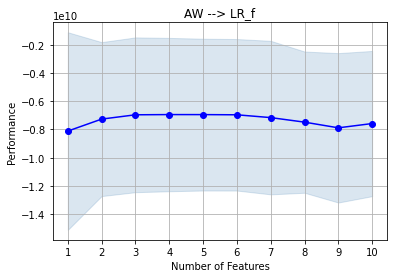




Sub-segment= "AW", Feature-selection model= "LR_b"
**************************************************
selected features: (0, 3, 4, 6, 7, 15, 16, 17, 18, 21)

Consumer Price Index_Monthly
Index_ Retail Sales_ Real (Volume)_Monthly
Industrial Production Index_Monthly
Long-Term Interest Rate Differential With USA_Monthly
BOP Goods Balance_ % of GDP_Quarterly
Interest Rate: Money Market_Quarterly
International Reserves Excluding Gold_ US$_Quarterly
M1 as Percent of GDP_Quarterly
NIA Imports of Goods & Non-Factor Service Deflator_ U.S. Dollar Basis_ Quarter-on-Quarter Percent Change_ SAAR_Quarterly
Nominal NIA Net Exports_ US$_Quarterly


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

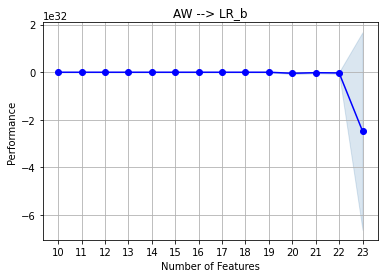




Sub-segment= "CY", Feature-selection model= "LR_f"
**************************************************
selected features: (1, 5, 9, 10, 11, 14, 16, 18, 20, 22)

Exchange Rate Index_ Period Average (LCU per US$)_Monthly
Interest Rate Spread: Long-Term minus Short-Term_Monthly
Broad Money Supply_ Period End_ US$_Quarterly
Deflator: Government Consumption_ euro_Quarterly
Domestic Investment Deflator_ Year-on-Year Percent Change_Quarterly
Growth Rate_ Broad Money Supply_ Period End_ Quarter-on-Quarter_ SAAR_ Percent Change_ US$_Quarterly
International Reserves Excluding Gold_ US$_Quarterly
NIA Imports of Goods & Non-Factor Service Deflator_ U.S. Dollar Basis_ Quarter-on-Quarter Percent Change_ SAAR_Quarterly
Nominal Fixed Investment_ US$_Quarterly
Unemployment Rate_Quarterly


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

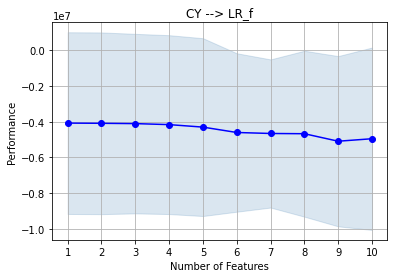




Sub-segment= "CY", Feature-selection model= "LR_b"
**************************************************
selected features: (1, 3, 4, 11, 12, 15, 16, 17, 18, 22)

Exchange Rate Index_ Period Average (LCU per US$)_Monthly
Index_ Retail Sales_ Real (Volume)_Monthly
Industrial Production Index_Monthly
Domestic Investment Deflator_ Year-on-Year Percent Change_Quarterly
Fiscal Balance: Overall (Government Savings)_ in LCU_ general government_Quarterly
Interest Rate: Money Market_Quarterly
International Reserves Excluding Gold_ US$_Quarterly
M1 as Percent of GDP_Quarterly
NIA Imports of Goods & Non-Factor Service Deflator_ U.S. Dollar Basis_ Quarter-on-Quarter Percent Change_ SAAR_Quarterly
Unemployment Rate_Quarterly


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

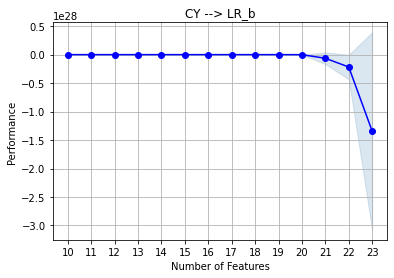

In [ ]:
# Visualizing the final results
#sub_seg_list = [i for i in df_X['sub_seg'].unique()]
sub_seg_list = ['AW', 'CY']
#model_list = ['LR_f', 'LR_b', 'LR_ff', 'LR_bf', 'RF_f', 'RF_b', 'RF_ff', 'RF_bf']
model_list = ['LR_f', 'LR_b']

#--

#this loop plots how each of the models' performance as the number of features are added/removed
for sub_seg in sub_seg_list:
  for model in model_list:
    print('Sub-segment= "{}", Feature-selection model= "{}"'.format(sub_seg, model))
    print('*'*50)
    print('selected features: {}\n'.format(fs_results[fs_results['sub_seg']== sub_seg][fs_results['model']== model]['feature_ids'].iloc[0]))

    feature_list = fs_results[fs_results['sub_seg']== sub_seg][fs_results['model']== model]['feature_list'].iloc[0]
    for feature in feature_list: print(feature)

    metrics = fs_results[fs_results['sub_seg']== sub_seg][fs_results['model']== model]['feature_selection_metrics'].iloc[0]
    fig1 = plot_SFS(metrics)
    plt.title(sub_seg+' --> '+model)
    plt.grid()
    plt.show()
    print('\n\n')